CT Reconstruction with TV Regularization
========================================

This example demonstrates the use of different optimization algorithms to
solve the TV-regularized CT problem, using SVMBIR <cite data-cite="svmbir-2020"/> for
tomographic projection.

In [1]:
import numpy as np

import jax

import matplotlib.pyplot as plt
import svmbir
from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, metric, plot
from scico.admm import ADMM, LinearSubproblemSolver
from scico.ladmm import LinearizedADMM
from scico.linop import Diagonal
from scico.linop.radon_svmbir import ParallelBeamProjector, SVMBIRWeightedSquaredL2Loss
from scico.primaldual import PDHG
from scico.util import device_info
plot.config_notebook_plotting()

Generate a ground truth image.

In [2]:
N = 256  # image size
density = 0.025  # attenuation density of the image
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.05, 0.02], gap=0.02, porosity=0.3), size=N - 10)
x_gt = x_gt / np.max(x_gt) * density
x_gt = np.pad(x_gt, 5)
x_gt[x_gt < 0] = 0

Generate tomographic projector and sinogram.

In [3]:
num_angles = int(N / 2)
num_channels = N
angles = snp.linspace(0, snp.pi, num_angles, dtype=snp.float32)
A = ParallelBeamProjector(x_gt.shape, angles, num_channels)
sino = A @ x_gt

2021-11-30 09:41:05.456645: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-11-30 09:41:05.456817: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.74.0 does not match DSO version 470.86.0 -- cannot find working devices in this configuration


Impose Poisson noise on sinogram. Higher max_intensity means less noise.

In [4]:
max_intensity = 2000
expected_counts = max_intensity * np.exp(-sino)
noisy_counts = np.random.poisson(expected_counts).astype(np.float32)
noisy_counts[noisy_counts == 0] = 1  # deal with 0s
y = -np.log(noisy_counts / max_intensity)

Reconstruct using default prior of SVMBIR <cite data-cite="svmbir-2020"/>.

In [5]:
weights = svmbir.calc_weights(y, weight_type="transmission")

x_mrf = svmbir.recon(
    np.array(y[:, np.newaxis]),
    np.array(angles),
    weights=weights[:, np.newaxis],
    num_rows=N,
    num_cols=N,
    positivity=True,
    verbose=0,
)[0]

Set up problem.

In [6]:
y, x0, weights = jax.device_put([y, x_mrf, weights])

λ = 1e-1  # L1 norm regularization parameter

f = SVMBIRWeightedSquaredL2Loss(y=y, A=A, W=Diagonal(weights), scale=0.5)
g = λ * functional.L21Norm()  # regularization functional

# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)

Solve via ADMM.

In [7]:
solve_admm = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[2e1],
    x0=x0,
    maxiter=50,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 10}),
    verbose=True,
)
print(f"Solving on {device_info()}\n")
x_admm = solve_admm.solve()
hist_admm = solve_admm.itstat_object.history(transpose=True)
print(metric.psnr(x_gt, x_admm))

Solving on CPU



Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  5.60e+00  9.019e+00    6.608e-01  5.695e-01


   1  1.17e+01  1.451e+01    3.493e-01  2.017e-01


   2  1.79e+01  1.518e+01    1.579e-01  1.232e-01


   3  2.40e+01  1.583e+01    9.792e-02  8.494e-02


   4  3.00e+01  1.590e+01    7.128e-02  6.509e-02


   5  3.58e+01  1.606e+01    5.554e-02  5.312e-02


   6  4.12e+01  1.606e+01    4.457e-02  4.562e-02


   7  4.60e+01  1.613e+01    3.672e-02  4.072e-02


   8  5.07e+01  1.614e+01    3.130e-02  3.631e-02


   9  5.54e+01  1.617e+01    2.714e-02  3.262e-02


  10  6.02e+01  1.619e+01    2.401e-02  2.953e-02


  11  6.49e+01  1.621e+01    2.149e-02  2.681e-02


  12  6.97e+01  1.622e+01    1.946e-02  2.449e-02


  13  7.45e+01  1.623e+01    1.781e-02  2.251e-02


  14  7.93e+01  1.624e+01    1.646e-02  2.073e-02


  15  8.41e+01  1.625e+01    1.532e-02  1.911e-02


  16  8.88e+01  1.626e+01    1.433e-02  1.771e-02


  17  9.36e+01  1.627e+01    1.347e-02  1.649e-02


  18  9.83e+01  1.627e+01    1.274e-02  1.538e-02


  19  1.03e+02  1.628e+01    1.207e-02  1.442e-02


  20  1.08e+02  1.628e+01    1.145e-02  1.355e-02


  21  1.13e+02  1.629e+01    1.089e-02  1.278e-02


  22  1.17e+02  1.629e+01    1.036e-02  1.207e-02


  23  1.22e+02  1.630e+01    9.880e-03  1.136e-02


  24  1.27e+02  1.630e+01    9.433e-03  1.074e-02


  25  1.32e+02  1.631e+01    9.021e-03  1.023e-02


  26  1.36e+02  1.631e+01    8.664e-03  9.714e-03


  27  1.41e+02  1.632e+01    8.336e-03  9.241e-03


  28  1.46e+02  1.632e+01    8.021e-03  8.838e-03


  29  1.51e+02  1.632e+01    7.731e-03  8.457e-03


  30  1.55e+02  1.632e+01    7.468e-03  8.075e-03


  31  1.60e+02  1.633e+01    7.221e-03  7.721e-03


  32  1.65e+02  1.633e+01    6.983e-03  7.396e-03


  33  1.70e+02  1.633e+01    6.754e-03  7.112e-03


  34  1.74e+02  1.633e+01    6.546e-03  6.855e-03


  35  1.79e+02  1.633e+01    6.350e-03  6.572e-03


  36  1.83e+02  1.634e+01    6.168e-03  6.310e-03


  37  1.88e+02  1.634e+01    5.997e-03  6.064e-03


  38  1.92e+02  1.634e+01    5.847e-03  5.843e-03


  39  1.96e+02  1.634e+01    5.698e-03  5.612e-03


  40  2.00e+02  1.634e+01    5.535e-03  5.336e-03


  41  2.04e+02  1.634e+01    5.409e-03  5.199e-03


  42  2.08e+02  1.635e+01    5.265e-03  4.913e-03


  43  2.12e+02  1.635e+01    5.154e-03  4.771e-03


  44  2.15e+02  1.635e+01    5.039e-03  4.656e-03


  45  2.19e+02  1.635e+01    4.904e-03  4.363e-03


  46  2.23e+02  1.635e+01    4.801e-03  4.248e-03


  47  2.27e+02  1.635e+01    4.691e-03  4.051e-03


  48  2.30e+02  1.635e+01    4.597e-03  3.957e-03


  49  2.34e+02  1.635e+01    4.508e-03  3.922e-03
22.914907


Solve via Linearized ADMM.

In [8]:
solver_ladmm = LinearizedADMM(
    f=f,
    g=g,
    C=C,
    mu=3e-2,
    nu=2e-1,
    x0=x0,
    maxiter=50,
    verbose=True,
)
x_ladmm = solver_ladmm.solve()
hist_ladmm = solver_ladmm.itstat_object.history(transpose=True)
print(metric.psnr(x_gt, x_ladmm))

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  1.96e+00  5.399e+00    1.073e+00  1.105e+00


   1  2.64e+00  5.632e+00    9.579e-01  7.521e-02


   2  3.33e+00  7.460e+00    7.317e-01  4.299e-01


   3  4.04e+00  1.107e+01    6.259e-01  6.593e-01


   4  4.71e+00  1.492e+01    6.609e-01  4.870e-01


   5  5.44e+00  1.685e+01    5.585e-01  3.106e-01


   6  6.13e+00  1.611e+01    4.300e-01  4.401e-01


   7  6.81e+00  1.418e+01    4.435e-01  3.684e-01


   8  7.51e+00  1.316e+01    3.873e-01  1.896e-01


   9  8.12e+00  1.412e+01    2.797e-01  3.088e-01


  10  8.75e+00  1.615e+01    3.244e-01  3.035e-01


  11  9.35e+00  1.740e+01    3.219e-01  1.607e-01


  12  1.01e+01  1.689e+01    2.269e-01  2.165e-01


  13  1.09e+01  1.537e+01    2.480e-01  2.384e-01


  14  1.15e+01  1.436e+01    2.550e-01  1.252e-01


  15  1.21e+01  1.476e+01    1.774e-01  1.680e-01


  16  1.28e+01  1.612e+01    1.982e-01  1.970e-01


  17  1.34e+01  1.712e+01    2.218e-01  1.108e-01


  18  1.40e+01  1.689e+01    1.567e-01  1.274e-01


  19  1.46e+01  1.577e+01    1.642e-01  1.630e-01


  20  1.52e+01  1.491e+01    1.885e-01  9.597e-02


  21  1.58e+01  1.510e+01    1.341e-01  1.052e-01


  22  1.64e+01  1.609e+01    1.384e-01  1.384e-01


  23  1.70e+01  1.691e+01    1.680e-01  8.474e-02


  24  1.76e+01  1.681e+01    1.224e-01  8.461e-02


  25  1.82e+01  1.597e+01    1.199e-01  1.183e-01


  26  1.88e+01  1.525e+01    1.483e-01  7.645e-02


  27  1.93e+01  1.533e+01    1.100e-01  7.303e-02


  28  2.00e+01  1.608e+01    1.045e-01  1.032e-01


  29  2.06e+01  1.676e+01    1.343e-01  6.777e-02


  30  2.12e+01  1.674e+01    1.021e-01  6.089e-02


  31  2.18e+01  1.609e+01    9.280e-02  9.017e-02


  32  2.24e+01  1.549e+01    1.211e-01  6.216e-02


  33  2.30e+01  1.549e+01    9.427e-02  5.362e-02


  34  2.37e+01  1.608e+01    8.305e-02  8.016e-02


  35  2.42e+01  1.666e+01    1.111e-01  5.567e-02


  36  2.48e+01  1.669e+01    8.871e-02  4.577e-02


  37  2.54e+01  1.618e+01    7.533e-02  7.116e-02


  38  2.60e+01  1.566e+01    1.018e-01  5.178e-02


  39  2.67e+01  1.563e+01    8.313e-02  4.073e-02


  40  2.73e+01  1.610e+01    6.867e-02  6.411e-02


  41  2.79e+01  1.659e+01    9.436e-02  4.690e-02


  42  2.84e+01  1.665e+01    7.896e-02  3.528e-02


  43  2.90e+01  1.623e+01    6.336e-02  5.739e-02


  44  2.95e+01  1.579e+01    8.743e-02  4.401e-02


  45  3.00e+01  1.573e+01    7.474e-02  3.162e-02


  46  3.06e+01  1.611e+01    5.867e-02  5.222e-02


  47  3.12e+01  1.654e+01    8.176e-02  4.034e-02


  48  3.17e+01  1.661e+01    7.150e-02  2.790e-02


  49  3.23e+01  1.628e+01    5.492e-02  4.701e-02
22.771376


Solve via PDHG.

In [9]:
solver_pdhg = PDHG(
    f=f,
    g=g,
    C=C,
    tau=2e-2,
    sigma=8e0,
    x0=x0,
    maxiter=50,
    verbose=True,
)
x_pdhg = solver_pdhg.solve()
hist_pdhg = solver_pdhg.itstat_object.history(transpose=True)
print(metric.psnr(x_gt, x_pdhg))

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  5.14e-01  2.263e+01    7.268e+00  1.060e+00


   1  1.14e+00  2.112e+01    6.964e+00  6.076e-01


   2  1.75e+00  1.981e+01    5.754e+00  3.886e-01


   3  2.32e+00  1.905e+01    4.767e+00  2.849e-01


   4  2.93e+00  1.863e+01    3.985e+00  2.239e-01


   5  3.54e+00  1.837e+01    3.405e+00  1.852e-01


   6  4.19e+00  1.818e+01    2.943e+00  1.577e-01


   7  4.76e+00  1.803e+01    2.575e+00  1.366e-01


   8  5.36e+00  1.789e+01    2.277e+00  1.197e-01


   9  5.98e+00  1.776e+01    2.031e+00  1.060e-01


  10  6.57e+00  1.764e+01    1.820e+00  9.466e-02


  11  7.12e+00  1.753e+01    1.635e+00  8.524e-02


  12  7.80e+00  1.743e+01    1.472e+00  7.722e-02


  13  8.40e+00  1.734e+01    1.329e+00  7.024e-02


  14  8.95e+00  1.726e+01    1.203e+00  6.411e-02


  15  9.55e+00  1.718e+01    1.092e+00  5.865e-02


  16  1.01e+01  1.711e+01    9.952e-01  5.383e-02


  17  1.07e+01  1.705e+01    9.084e-01  4.961e-02


  18  1.12e+01  1.699e+01    8.295e-01  4.592e-02


  19  1.18e+01  1.694e+01    7.575e-01  4.266e-02


  20  1.23e+01  1.690e+01    6.921e-01  3.974e-02


  21  1.30e+01  1.686e+01    6.327e-01  3.710e-02


  22  1.35e+01  1.682e+01    5.795e-01  3.464e-02


  23  1.41e+01  1.679e+01    5.327e-01  3.236e-02


  24  1.47e+01  1.675e+01    4.912e-01  3.025e-02


  25  1.54e+01  1.673e+01    4.536e-01  2.837e-02


  26  1.60e+01  1.670e+01    4.185e-01  2.673e-02


  27  1.66e+01  1.668e+01    3.852e-01  2.530e-02


  28  1.71e+01  1.666e+01    3.534e-01  2.404e-02


  29  1.76e+01  1.664e+01    3.238e-01  2.294e-02


  30  1.82e+01  1.663e+01    2.964e-01  2.192e-02


  31  1.87e+01  1.662e+01    2.720e-01  2.098e-02


  32  1.92e+01  1.661e+01    2.510e-01  2.009e-02


  33  1.97e+01  1.660e+01    2.333e-01  1.926e-02


  34  2.02e+01  1.659e+01    2.182e-01  1.847e-02


  35  2.07e+01  1.658e+01    2.051e-01  1.775e-02


  36  2.13e+01  1.657e+01    1.934e-01  1.709e-02


  37  2.18e+01  1.656e+01    1.824e-01  1.648e-02


  38  2.24e+01  1.655e+01    1.720e-01  1.591e-02


  39  2.29e+01  1.654e+01    1.624e-01  1.539e-02


  40  2.34e+01  1.654e+01    1.534e-01  1.491e-02


  41  2.39e+01  1.653e+01    1.447e-01  1.448e-02


  42  2.44e+01  1.653e+01    1.365e-01  1.408e-02


  43  2.50e+01  1.652e+01    1.287e-01  1.371e-02


  44  2.55e+01  1.652e+01    1.214e-01  1.336e-02


  45  2.60e+01  1.651e+01    1.147e-01  1.302e-02


  46  2.66e+01  1.651e+01    1.086e-01  1.270e-02


  47  2.72e+01  1.651e+01    1.029e-01  1.240e-02


  48  2.78e+01  1.650e+01    9.770e-02  1.212e-02


  49  2.82e+01  1.650e+01    9.282e-02  1.184e-02
22.835768


Show the recovered images.

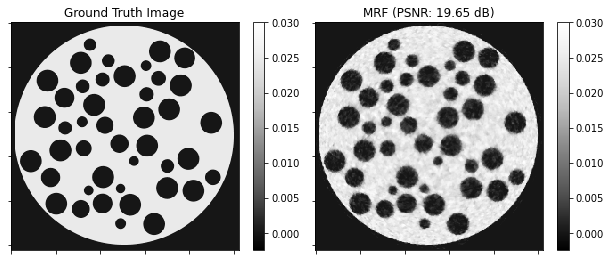

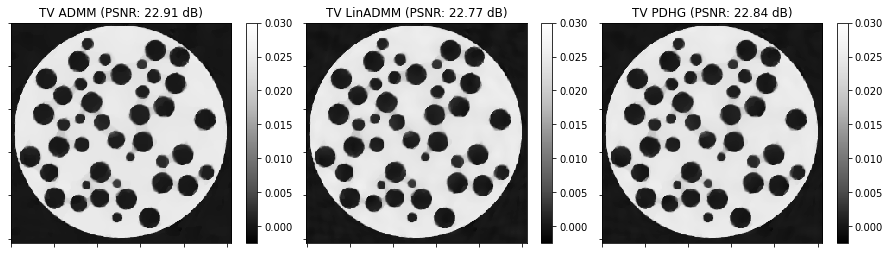

In [10]:
norm = plot.matplotlib.colors.Normalize(vmin=-0.1 * density, vmax=1.2 * density)
fig, ax = plt.subplots(1, 2, figsize=[10, 5])
plot.imview(img=x_gt, title="Ground Truth Image", cbar=True, fig=fig, ax=ax[0], norm=norm)
plot.imview(
    img=x_mrf,
    title=f"MRF (PSNR: {metric.psnr(x_gt, x_mrf):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
fig.show()

fig, ax = plt.subplots(1, 3, figsize=[15, 5])
plot.imview(
    img=x_admm,
    title=f"TV ADMM (PSNR: {metric.psnr(x_gt, x_admm):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[0],
    norm=norm,
)
plot.imview(
    img=x_ladmm,
    title=f"TV LinADMM (PSNR: {metric.psnr(x_gt, x_ladmm):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[1],
    norm=norm,
)
plot.imview(
    img=x_pdhg,
    title=f"TV PDHG (PSNR: {metric.psnr(x_gt, x_pdhg):.2f} dB)",
    cbar=True,
    fig=fig,
    ax=ax[2],
    norm=norm,
)
fig.show()

Plot convergence statistics.

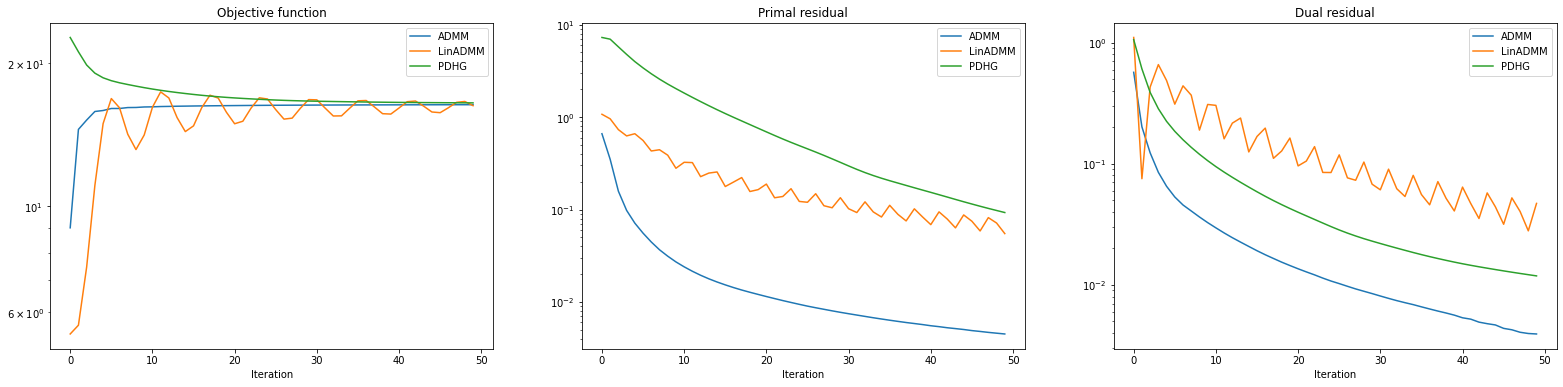

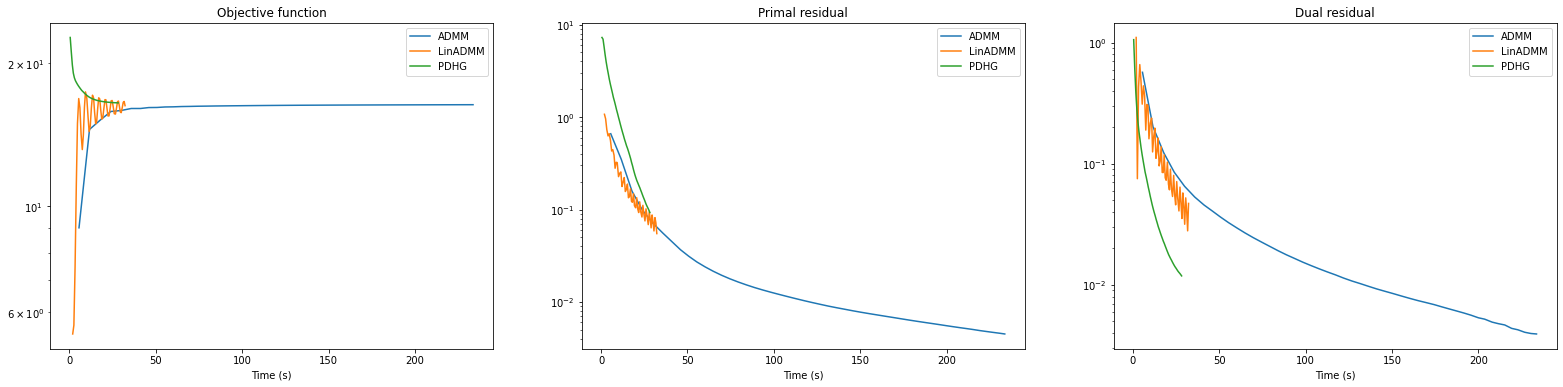

In [11]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Primal_Rsdl, hist_ladmm.Primal_Rsdl, hist_pdhg.Primal_Rsdl)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Iteration",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()

fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(27, 6))
plot.plot(
    snp.vstack((hist_admm.Objective, hist_ladmm.Objective, hist_pdhg.Objective)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Objective function",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist_admm.Primal_Rsdl, hist_ladmm.Primal_Rsdl, hist_pdhg.Primal_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Primal residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[1],
)
plot.plot(
    snp.vstack((hist_admm.Dual_Rsdl, hist_ladmm.Dual_Rsdl, hist_pdhg.Dual_Rsdl)).T,
    snp.vstack((hist_admm.Time, hist_ladmm.Time, hist_pdhg.Time)).T,
    ptyp="semilogy",
    title="Dual residual",
    xlbl="Time (s)",
    lgnd=("ADMM", "LinADMM", "PDHG"),
    fig=fig,
    ax=ax[2],
)
fig.show()